# Quick and dirty test of rough draft of SOMPZInformer

In [1]:
# usual imports
import os
import numpy as np
from rail.core.utils import RAILDIR
#from rail.estimation.algos.sompz_version.utils import RAIL_SOMPZ_DIR
#from rail.pipelines.estimation.inform_all import InformPipeline
from rail.core import common_params
import matplotlib.pyplot as plt

In [2]:
from rail.estimation.algos.sompz import SOMPZInformer

In [3]:
from rail.core.data import TableHandle
from rail.core.stage import RailStage

In [4]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

read in some test data for the "wide" som, it's just 20,000 mock ugrizy magnitudes and errors from cosmodc2

In [5]:
from rail.core.utils import find_rail_file
#trainFile = find_rail_file('examples_data/testdata/test_dc2_training_9816.hdf5')
testFile = find_rail_file('examples_data/testdata/test_dc2_validation_9816.hdf5')
#deep_data = DS.read_file("training_data", TableHandle, trainFile)
wide_data = DS.read_file("input_wide_data", TableHandle, testFile)

I have copied the file that Justin made to this directory and will read that fits file in to test the "deep" som.  If you have the file somewhere else, then update the "hsc_file" path in the cell below:

In [8]:
datadir = '/global/cfs/projectdirs/desc-pz/users/jmyles/sompz_desc/' 
hsc_file = os.path.join(datadir, "hsc_deep_incl_nir_incl_specz_TEST_ONLY_NO_SCIENCE_2023-10-18_common_deep_col_prefix_dropout_placeholder.fits")
deep_data = DS.read_file("training_data", TableHandle, hsc_file)

To speed things up a bit, I'm going to grab 10% of the data and actually use that.  It should work with the big data, but this will be faster to train up the som for a quick demo:

In [9]:
subset = deep_data()[::10]

In [10]:
smaller_data = DS.add_data("smaller_data", subset, TableHandle)

create a few lists of names that we'll need for the names of the input columns that we'll used in the SOM, along with their errors.

In [11]:
bands = ['u','g','r','i','z','y', 'J','H', 'K']
deepbands = []
deeperrs = []
zeropts = []
for band in bands:
    deepbands.append(f'flux_DEEP_{band}')
    deeperrs.append(f'flux_err_DEEP_{band}')
    zeropts.append(30.)

In [12]:
deepbands

['flux_DEEP_u',
 'flux_DEEP_g',
 'flux_DEEP_r',
 'flux_DEEP_i',
 'flux_DEEP_z',
 'flux_DEEP_y',
 'flux_DEEP_J',
 'flux_DEEP_H',
 'flux_DEEP_K']

make a dictionary of the parameters that we'll feed into the informer for the deep som.  Because we're using HSC data we need the non-default names fo the input columns (`inputs_deep`) and the errors (`input_errs_deep`).  We'll feed in a list for the zero points (`zero_points`) as well, as eventually we'll want to add a check to make sure all three of those have the same length:

In [13]:
som_params = dict(inputs_deep=deepbands, input_errs_deep=deeperrs, zero_points_deep=zeropts, 
                  convert_to_flux=False, set_threshold=True)

deep_groupname and hdf5_groupname (along with an unused wide_groupname) have to do with hdf5 groups and how we read the data, hdf5_groupname is not used in this stage, but it is expected by the parent class, so I'm setting it here:

In [14]:
som_inform = SOMPZInformer.make_stage(name="som_informer", deep_groupname='', hdf5_groupname='',
                                      model="TEST_HSC_DC2_model.pkl", **som_params)

Now, run the informer:

In [15]:
som_inform.inform(smaller_data, wide_data)

18689 galaxies in deep sample
20449 galaxies in wide sample
Training deep SOM...
Training 0
Training 10000


/Users/jmyles/miniconda3/envs/rail_sompz/lib/python3.10/site-packages/rail/estimation/algos/som.py:372: RuntimeWarning: divide by zero encountered in log
  tmp = w * np.log(2 * vnS) + dn
/Users/jmyles/miniconda3/envs/rail_sompz/lib/python3.10/site-packages/rail/estimation/algos/som.py:413: RuntimeWarning: divide by zero encountered in divide
  factor = np.maximum(1., vf) / vn


inf tmp at (array([ 0,  0,  0, ..., 40, 40, 40]), array([  0,   1,   2, ..., 509, 510, 511]), array([0, 0, 0, ..., 0, 0, 0]), array([2, 2, 2, ..., 2, 2, 2]))
False False False True
inf tmp at (array([ 0,  0,  0, ..., 40, 40, 40]), array([  0,   1,   2, ..., 509, 510, 511]), array([0, 0, 0, ..., 0, 0, 0]), array([2, 2, 2, ..., 2, 2, 2]))
False False False True
inf tmp at (array([ 0,  0,  0, ..., 40, 40, 40]), array([  0,   1,   2, ..., 509, 510, 511]), array([0, 0, 0, ..., 0, 0, 0]), array([3, 3, 3, ..., 3, 3, 3]))
False False False True
inf tmp at (array([ 0,  0,  0, ..., 40, 40, 40]), array([  0,   1,   2, ..., 509, 510, 511]), array([0, 0, 0, ..., 0, 0, 0]), array([3, 3, 3, ..., 3, 3, 3]))
False False False True
Training wide SOM...
Training 0
Training 10000
Training 20000
Inserting handle into data store.  model_som_informer: inprogress_TEST_HSC_DC2_model.pkl, som_informer


{'deep_som': <rail.estimation.algos.som.NoiseSOM at 0x16863ff40>,
 'wide_som': <rail.estimation.algos.som.NoiseSOM at 0x1106f79d0>,
 'deep_columns': ['flux_DEEP_u',
  'flux_DEEP_g',
  'flux_DEEP_r',
  'flux_DEEP_i',
  'flux_DEEP_z',
  'flux_DEEP_y',
  'flux_DEEP_J',
  'flux_DEEP_H',
  'flux_DEEP_K'],
 'deep_err_columns': ['flux_err_DEEP_u',
  'flux_err_DEEP_g',
  'flux_err_DEEP_r',
  'flux_err_DEEP_i',
  'flux_err_DEEP_z',
  'flux_err_DEEP_y',
  'flux_err_DEEP_J',
  'flux_err_DEEP_H',
  'flux_err_DEEP_K'],
 'wide_columns': ['mag_u_lsst',
  'mag_g_lsst',
  'mag_r_lsst',
  'mag_i_lsst',
  'mag_z_lsst',
  'mag_y_lsst'],
 'wide_err_columns': ['mag_err_u_lsst',
  'mag_err_g_lsst',
  'mag_err_r_lsst',
  'mag_err_i_lsst',
  'mag_err_z_lsst',
  'mag_err_y_lsst']}

Let's look at the results by reading the model we just wrote out, `TEST_HSC_DC2_model.pkl` and looking at what it contains.  It should be a dictionary that contains two soms: `deep_som` and `wide_som`, along with the `deep_columns`, `wide_columns`, `deep_err_columns`, and `wide_err_columns` lists.  I think we'll want to store these as they basically define the ordering of the columns and errors, and we'll want that the same for data that we pass in (if we pass in more data?  I need to look at how the estimate stage works...)

In [16]:
import pickle

In [17]:
with open("TEST_HSC_DC2_model.pkl", "rb") as f:
    model = pickle.load(f)

In [18]:
model

{'deep_som': <rail.estimation.algos.som.NoiseSOM at 0x168685600>,
 'wide_som': <rail.estimation.algos.som.NoiseSOM at 0x16863fe80>,
 'deep_columns': ['flux_DEEP_u',
  'flux_DEEP_g',
  'flux_DEEP_r',
  'flux_DEEP_i',
  'flux_DEEP_z',
  'flux_DEEP_y',
  'flux_DEEP_J',
  'flux_DEEP_H',
  'flux_DEEP_K'],
 'deep_err_columns': ['flux_err_DEEP_u',
  'flux_err_DEEP_g',
  'flux_err_DEEP_r',
  'flux_err_DEEP_i',
  'flux_err_DEEP_z',
  'flux_err_DEEP_y',
  'flux_err_DEEP_J',
  'flux_err_DEEP_H',
  'flux_err_DEEP_K'],
 'wide_columns': ['mag_u_lsst',
  'mag_g_lsst',
  'mag_r_lsst',
  'mag_i_lsst',
  'mag_z_lsst',
  'mag_y_lsst'],
 'wide_err_columns': ['mag_err_u_lsst',
  'mag_err_g_lsst',
  'mag_err_r_lsst',
  'mag_err_i_lsst',
  'mag_err_z_lsst',
  'mag_err_y_lsst']}

In [19]:
import rail.estimation.algos.som as SOMFUNCS

<Figure size 1000x900 with 0 Axes>

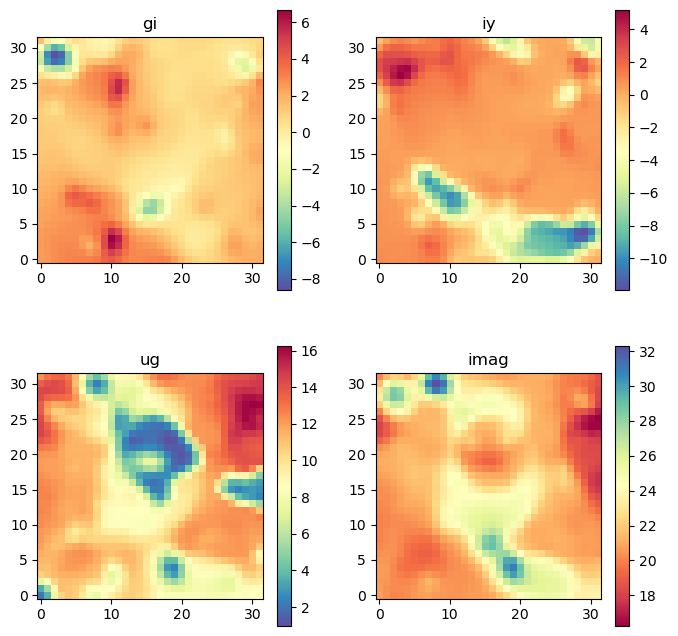

In [20]:
SOMFUNCS.somDomainColorsnok(model['deep_som'])

<Figure size 600x700 with 0 Axes>

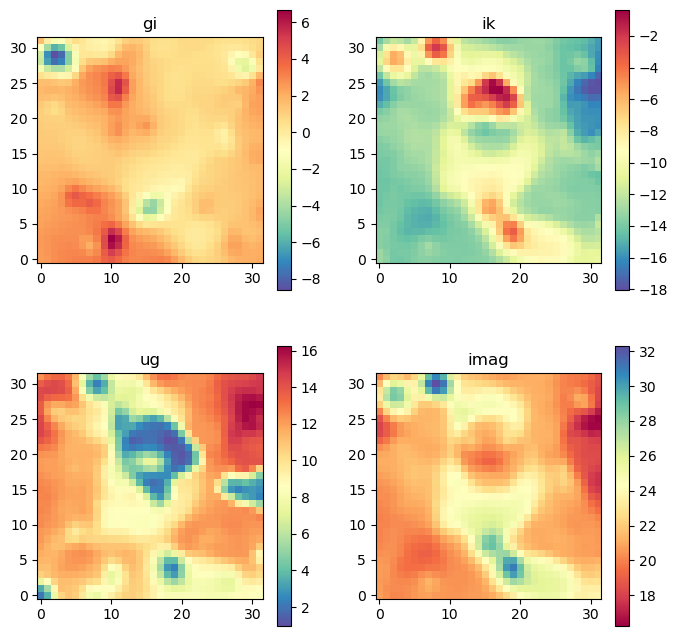

In [21]:
SOMFUNCS.somDomainColors(model['deep_som'])

<Figure size 1000x900 with 0 Axes>

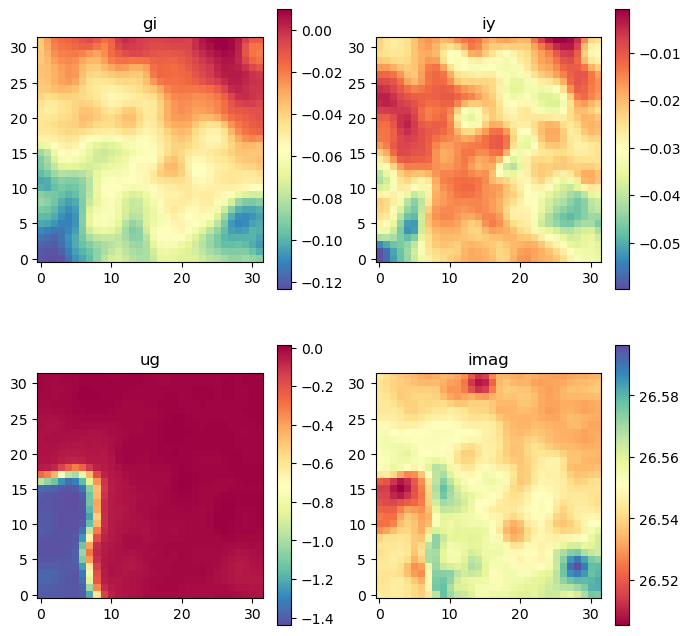

In [22]:
SOMFUNCS.somDomainColorsnok(model['wide_som'])

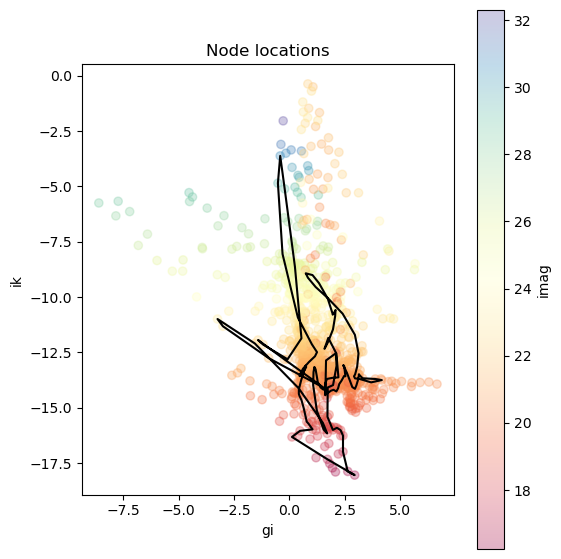

In [23]:
SOMFUNCS.somPlot2d(model['deep_som'])